# Exploratory Data Analysis

The primary goal of this analysis is to load, inspect, and visualize the store-item demand to uncover underlying patterns, trends and seasonality. The insights gathered here will inform the feature engineering and modeling strategy.

### Executive Summary

This analysis of five years of daily sales data reveals a highly predictable business with clear patterns that can be used for future forecasting. The key findings are:

1. **Consistent Annual Growth**

    The business shows a steady and positive long-term trend with sales growing year-over-year.

2. **Powerful Seasonal Rhythms**

    Sales performance is driven by two primary cycles. A weekly rhythm that build to a Sunday peak, and a larger annual wave that rises to a summer high.

3. **Holiday Periods Drive Peak Sales**

    The most significant "surprise" sales peaks are consistently driven by the Thanksgiving holiday period, confirming it as an important event for business.

4. **Busier Periods are Less Predictable**

    There is a clear link between higher sales volume and increased variability, meanin that the busiest days and months are also the hardest to predict.

### About the Data

The dataset used in this analysis is from the Kaggle competition, "Store Item Demand Forecasting Challenge." It contains five years of daily sales data for 50 different items across 10 different stores. The primary objective is to accurately forecast the demand for these items. This initial exploration focuses on understanding the overall structure and patterns within this historical sales data.

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from statsmodels.graphics.tsaplots import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta

# Loading the sales data
df = pd.read_csv('../data/train.csv')

# Setting plot style and palette
sns.set_style('whitegrid')
palette = sns.color_palette()

In [85]:
# Convert the 'date' column to a datetime object
df['date'] = pd.to_datetime(df['date'])

# Creating new features from the date
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek   # Where Monday = 0 and Sunday = 6

# Checking that the new columns are correctly added
df.head()

,date,store,item,sales,year,month,dayofweek
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


## Overall Sales Trend

Plotting the total sales over time to do a visual analysis of the sales data.

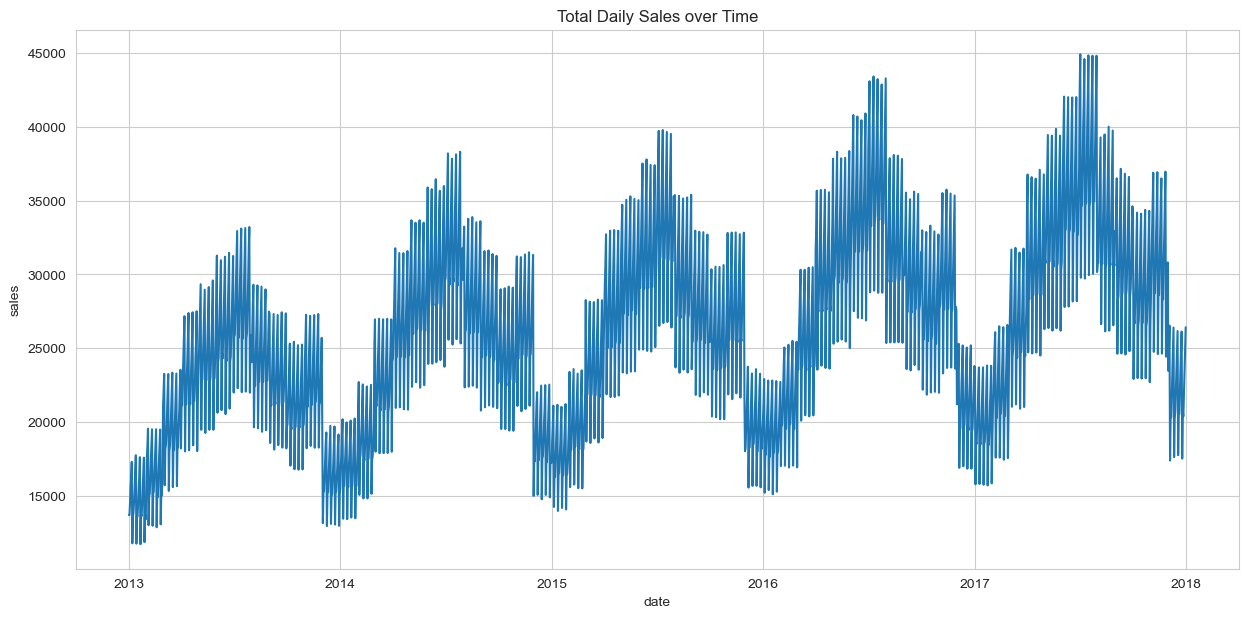

In [86]:
# Aggregate the sales by date
daily_sales = df.groupby('date')['sales'].sum().reset_index()

# Creating the plot
plt.figure(figsize=(15, 7))
sns.lineplot(x='date', y='sales', data=daily_sales)
plt.title('Total Daily Sales over Time')
plt.show()

### Analysis of Overall Sales Trend

This chart illustrates the total daily sales over a five-year period. It clearly shows three distinct patterns that are critical for understanding the sales performance.

1. **There is a consistent upward trend**

    Tracing the lowest points of the graph, we notice that the sales floor increases each year. The same holds true for the peaks. This steady year-over-year growth indicates a healthy and expanding business.

2. **Strong and predictable annual seasonality**

    The sales data forms a clear and yearly wave-like pattern. Sales consistently peaks during summer before declining to their lowest point during winter. This indicates a strong annual seasonality.

3. **There is a rapid repeating cycle**

    Looking closely at the graph we can see that it is made out of dense, sharp spikes. These rapid movements point at a shorter, possibly weekly, sales rhythm of slow and busy days repeating over and over.

In summary, the sales data are characterized by the patterns discussed above. To better understand these patterns we will use box plots to explore weekly and monthly distributions in greater detail.

## Monthly and Weekly Seasonality

To gain better insights from the seasonality observed above, boxplots will be made to see the statistics of individual days and months.

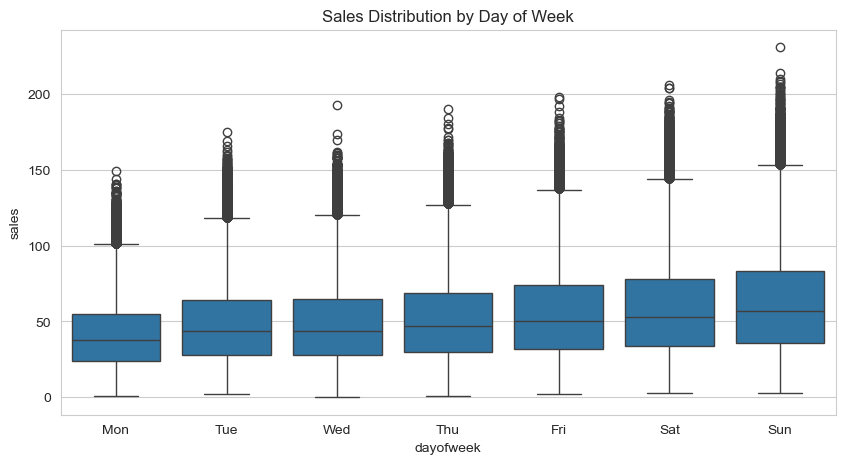

In [87]:
# Sales by Day of Week
plt.figure(figsize=(10, 5))
sns.boxplot(x='dayofweek', y='sales', data=df)
plt.title('Sales Distribution by Day of Week')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], 
           labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

### Analysis of Sales Distribution by Day of Week

This chart shows us the rhythm of sales throughout the week. From it we gain two main insights:

1. **The Week Builds to a Weekend Peak**

    The typical sales day is represented by the line inside each blue box. We can clearly see that the line climbs higher each day from Monday, reaching its highest point on Sunday. This confirms a predictable weekly cycle where sales build towards a weekend peak.

2. **A Busier Day Brings Less Predictability**

    From the height of the blue boxes themselves we can see the variability for each sales day. We notice how the height increases throughout the week. Monday's short box show very consistent sales, while Sunday's taller box show a wider range of outcomes. As such, the busiest days are also the least predictable.

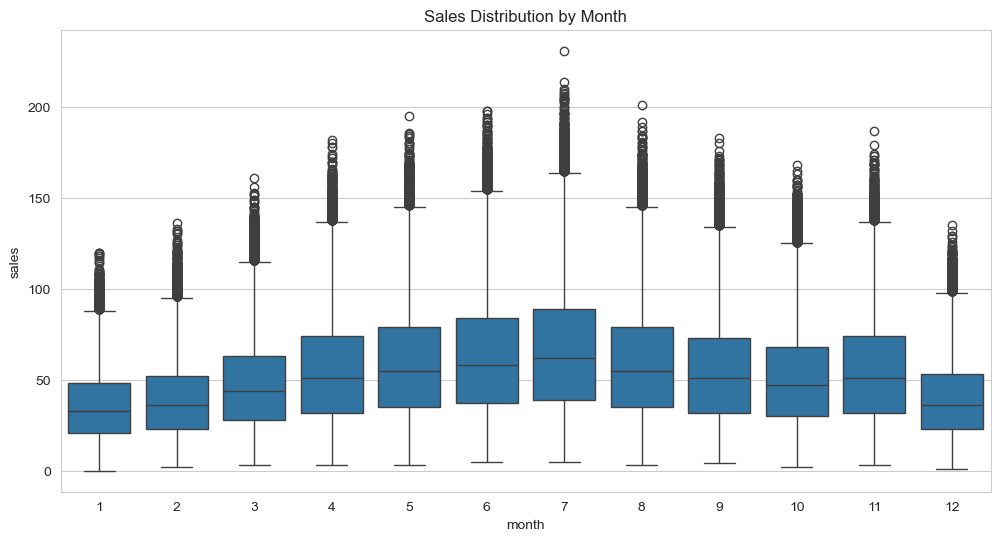

In [88]:
# Sales by Month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='sales', data=df)
plt.title('Sales Distribution by Month')
plt.show()

### Analysis of Sales Distribution by Month

Just as we explored the weekly rhythm, this chart lets us take a closer look at the annual wave we saw in the first plot. It reveals a clear and predictable seasonal story.

1. **A Clear Summer Peak in Sales**

    Following the line inside each box again, the typical performance for the month, we see a distinct arch stretching across the year. Sales start the year at their lowest, building up through the spring, reaching their highest point in July. After this peak, the sales gradually decline towards the end of the year, with a slight bump during November.

2. **The busiest months are less predictable**

    A familiar pattern of variability emerges, showing that with increased typical sales comes more uncertainty. The short boxes and comparatievly short lines above each box tell us that almost all sales days fall within a narrower, more predictable range. In contrast, the tall boxes and longer lines during summer show a wider spread in outcomes, meaning that the sales days are less consistent month-to-month during summer.

3. **Exceptional Sales Days are a Summer Phenomenon**

    The lines and dots extending above the boxes show us days with unusually high sales. These are more frequent and reach higher values during the summer months. This suggests that the forces driving the best sales days are strongest during the peak season.

## Weekly Sales Pattern

After visually identifying repeating patterns in the sales data, we can use an Autocorrelation Function (ACF) plot to statistically measure and confirm these patterns. This plot will show the strength of the corrolation between daily sales figures and sales from previous days, providing statistical evidence for the weekly cycle observed in the box plot above.

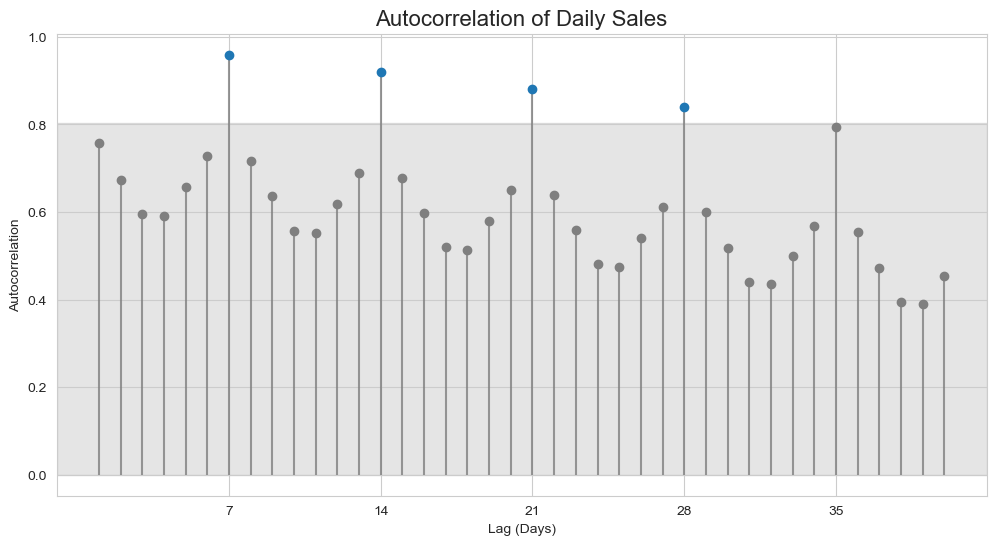

In [89]:
# Calculate the ACF and confidence intervals
acf_values, confint = acf(daily_sales['sales'], nlags=40, alpha=0.05)

# Determine the significance treshold from the confidence interval
# This is the line above which a correlation is satistically significant
significance_threshold = confint[1, 1]

# We don't need the value for Lag 0, as it provides no real insight into the underlying patterns
lags = range(1, 41)
acf_values_no_lag0 = acf_values[1:]

# Plotting
plt.figure(figsize=(12, 6))

# Plot the lollipop sticks
plt.vlines(lags, [0], acf_values_no_lag0, color=palette[7], alpha=0.8)

# Differentiate significant and non-significant markers
# Create a boolean array: True if significant, False otherwise
is_significant = np.abs(acf_values_no_lag0) > significance_threshold

# Plot non-significant markers in grey
plt.plot(np.array(lags)[~is_significant], acf_values_no_lag0[~is_significant],
         marker='o', linestyle='none', color=palette[7])

# Plot significant markers in blue
plt.plot(np.array(lags)[is_significant], acf_values_no_lag0[is_significant],
         marker='o', linestyle='none', color=palette[0])

# Add the shaded confidence interval region
plt.axhspan(0, significance_threshold,
            alpha=0.2, color=palette[7], zorder=0)

# Add titles and labels
plt.title('Autocorrelation of Daily Sales', fontsize=16)
plt.xlabel('Lag (Days)')
plt.xticks(np.arange(7, 41, 7))
plt.ylabel('Autocorrelation')
plt.show()

### Analysis of Weekly Autocorrelation

To statistically prove the weekly pattern seen in earlier charts, this analysis measures the "echo" of past sales. Any correlation score rising above the grey "randomness zone" is considered a significant pattern, not just random noise. The analysis further confirms the weekly pattern:

1. **A Statistically Proven Weekly Cycle**

    Notice how four peaks in the chart stands out, appearing precisely at the 7, 14, 21 and 28th day-marks. This is the statistical proof of a strong weekly cycle, confirming that sales on any given day are an echo from sales from the same day in previous weeks.


## Identifying Special Events

Our analysis has captured the regular sales trend and weekly rhythm. Now we're going to focus on the exceptional days that don't fit these patterns. Since the data's origin is unspecified, our hypothesis is that these exceptions are driven by US holidays, a common and powerful pattern in retail.

To test this hypothesis, we will use a method called Time-Series Decomposition. This technique isolates the residuals, "unexplained", part of the sales data, giving us a data-driven selection of surprising sales peaks to compare against the holiday calendar.

In [114]:
# We need a datetime index for the decomposition
daily_sales_ts = daily_sales.set_index('date')

# Performing a multiplicative decomposition, specifying the weekly period (7 days)
decomposition = seasonal_decompose(daily_sales_ts['sales'], model='multiplicative', period=7)

# Extract the residuals and drop NaN values
residuals = decomposition.resid.reset_index().dropna()
residuals.columns = ['date', 'residuals']

# Generating holiday data
us_holidays = holidays.US(years=range(2013, 2018))
holiday_window = set()
for date in us_holidays.keys():
    for i in range(-1, 6): # Defining the size of the holiday window
        holiday_date = pd.to_datetime(date + timedelta(days=i))
        holiday_window.add(holiday_date)

def plot_top_anomalies(residuals_df, daily_sales_df, n_anomalies, holiday_window):
    """
    Selects and plots the top sales anomalies.
    """
    # Selection logic
    if 0 < n_anomalies < 1:
        count = int(len(daily_sales_df) * n_anomalies)
        title_string = f"Top {n_anomalies:.0%} of Anomalous Sales Days"
    else:
        count = int(n_anomalies)
        title_string = f"Top {count} Anomalous Sales Days"
    
    # Get the top n days
    top_anomalies = residuals_df.nlargest(count, 'residuals')

    # Add features needed for plotting
    top_anomalies['year'] = top_anomalies['date'].dt.year
    top_anomalies['dayofyear'] = top_anomalies['date'].dt.dayofyear
    top_anomalies['is_holiday_period'] = top_anomalies['date'].isin(holiday_window)

    # Custom palette
    custom_palette = {False: palette[7], True: palette[0]}

    # Plotting
    plt.figure(figsize=(15, 7))
    sns.scatterplot(
        data=top_anomalies,
        x='dayofyear',
        y='residuals',
        hue='is_holiday_period',  # Color by holiday status
        palette=custom_palette,
        s=200,                    # Set a large, uniform size for all points
        legend='full'
    )  
    
    # Labels and Ticks
    month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.xticks(ticks=month_starts, labels=month_names)

    plt.title(f'{title_string} By Time of Year', fontsize=16)
    plt.xlabel('Month')
    plt.ylabel('Anomaly Strength (Residual)')
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.show()


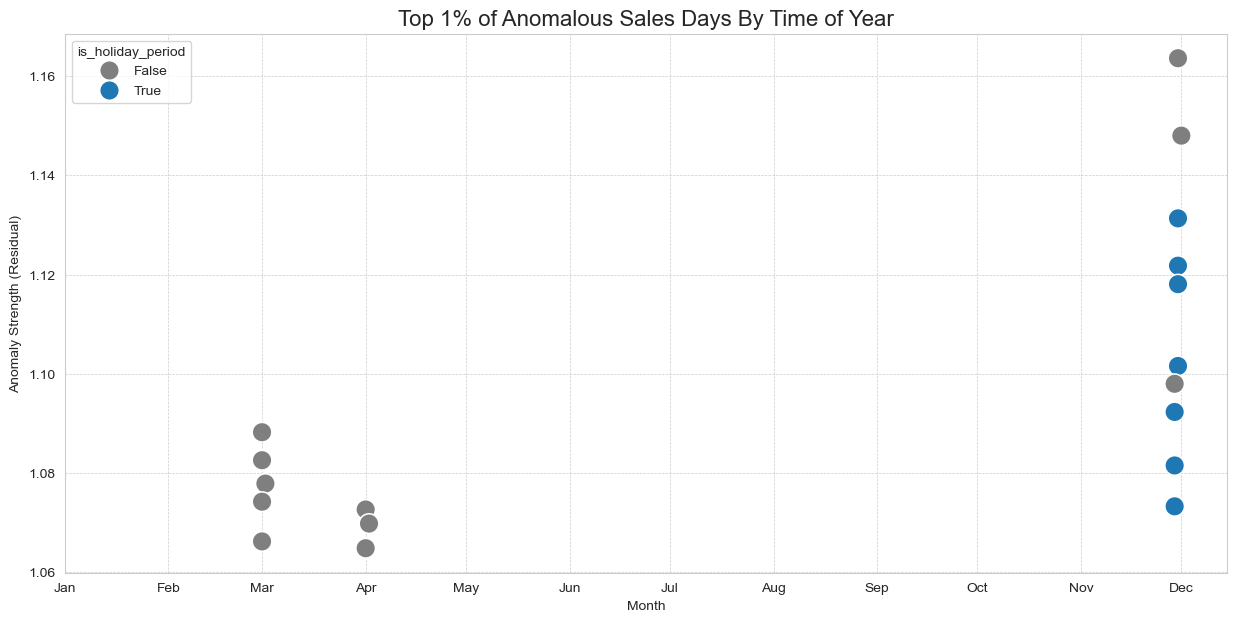

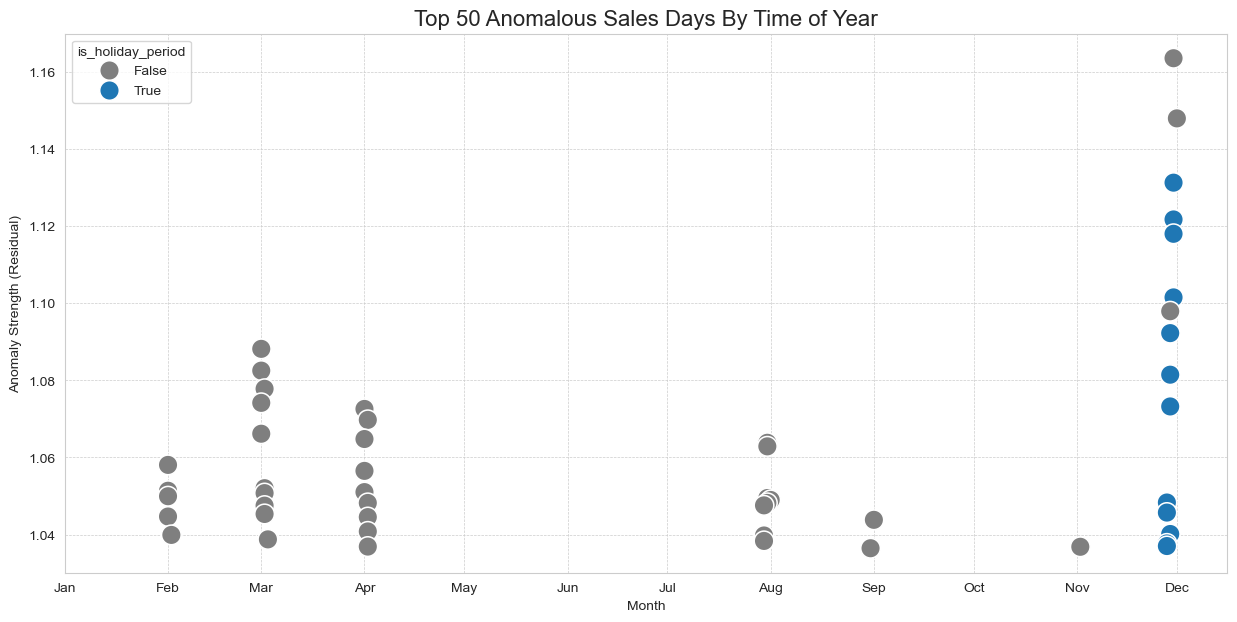

In [116]:
# Top 1% of Anomalies
plot_top_anomalies(residuals_df=residuals, 
                   daily_sales_df=daily_sales, 
                   n_anomalies=0.01, 
                   holiday_window=holiday_window
                )

# Top 50 Anomalies
plot_top_anomalies(residuals_df=residuals, 
                   daily_sales_df=daily_sales, 
                   n_anomalies=50, 
                   holiday_window=holiday_window
                )

### Analysis of Anomalous Sales Days

To focus in on the days that don't follow the normal pattern we created the two plots above. Looking at these "surprise" days through a view of only the Top 1% of days, and a wider view of the Top 50, to see if they tell their own predictable story.

This approach revealed two distinct kinds of special events:

1. **The Holiday Period Creates the Strongest Anomaly Cluster**

    Looking at the "Top 1%" plot we notice a cluster of unusual results at the end of November. The majority of these results are within the holiday period (blue dots). This is around the time of Thanksgiving, which indicates that the Thanksgiving period makes the most significant and predictable period of surprise sales activity.

2. **A Wider View Reveals a Second Pattern**

    The "Top 50" plot provides a broader context and with it a new pattern emerges in the denser cluster of grey dots between the start of February and April. These are not, according to our approach, tied to any US holidays. This suggests a second, more subtle type of event is at play, likely related to promotions at the start of those months.

## Conclusion and Next Steps

This exploratory analysis has uncovered the primary patterns shaping the sales data. Starting with a broad view of the five-year trend down to the monthly and daily details, we now have a clearer picture of the features the future model will need to learn.

The key takeaways are:

1. **Consistent Growth**

    There is a clear, positive long-term trend, indicating that sales are growing year-over-year.

2. **Two Powerful Rhythms**

    Sales are affected by two distinct and predictable seasonal cycles. A Weekly Rhythm that builds from a Monday low to a Sunday high, and an Annual Wave that rises from a winter low to a summer high in July.

3. **Predictable Events**

    "Surprise" sales peaks are not random. The largest are consistently driven by the Thanksgiving holiday period, while a secondary pattern is tied to the start of certain months.

4. **Volatility is Seasonal**

    The periods of higher sales are also periods of higher variability. This means that the model may find it easier to predict demand during slower periods.

### Implications for Modeling

These insights directly inform the next steps in feature engineering and model selection:

1. **Time-Based Features are Crucial**

    The model must have features that can capture these patterns. The 'year', 'month' and 'dayofweek' features created during the analysis will be the foundation of the model.

2. **Handling Trend and Seasonality**

    A successful model will need to be able to account for both the long-term upward trend and the dual seasonality. This suggests that models like SARIMA, Prophet or tree-based models with appropriate time-based features will be strong candidates.

3. **Event-Based Features are Necessary**

    To account for predictable spikes, we will create different specific features from major holidays like Thanksgiving, and a separate "start-of-month" feature.

With the exploratory analysis concluded, we are now prepared to move on to the feature engineering and modeling phase.
